Using cache found in /home/aryaman/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/aryaman/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/aryaman/.cache/torch/hub/intel-isl_MiDaS_master


0.03246018614110875
[[1.62300931]]


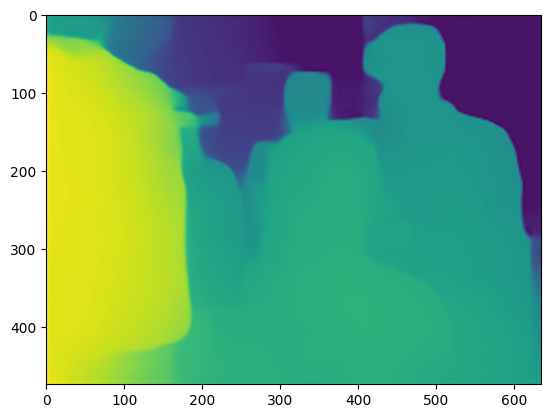

In [10]:
# Import dependencies
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt 
from PIL import Image
from scipy.interpolate import RectBivariateSpline
# Download the MiDaS
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
midas.to('cpu')
midas.eval()
# Input transformation pipeline
transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
transform = transforms.small_transform 
img=Image.open('/home/aryaman/Downloads/png2jpg/test_ss.jpg')
#img=img.resize((256,256))
img=np.array(img)
imgbatch = transform(img).to('cpu')
# Make a prediction
with torch.no_grad(): 
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size = img.shape[:2], 
        mode='bicubic', 
        align_corners=False
    ).squeeze()
    output = prediction.cpu().numpy()
output_norm = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(output_norm)
h,w = output_norm.shape
x_grid = np.arange(w)
y_grid = np.arange(h)
spline = RectBivariateSpline(y_grid, x_grid, output_norm)
depth_scale = 1
depth_mid_filt = spline(0,0)#y,x
depth_midas = depth_to_distance(depth_mid_filt, depth_scale)
depth_mid_filt = (apply_ema_filter(depth_midas)/10)[0][0]
"""
cv2.putText(img, "Depth in unit: " + str(
            np.format_float_positional(depth_midas , precision=3)), (20, 50), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (255, 255, 255), 3)
"""
print(depth_mid_filt)
print(depth_midas)

In [5]:
def depth_to_distance(depth_value,depth_scale):
    return 1.0 / (depth_value*depth_scale)
h,w = output_norm.shape
x_grid = np.arange(w)
y_grid = np.arange(h)
spline = RectBivariateSpline(y_grid, x_grid, output_norm)
depth_scale = 1
depth_mid_filt = spline(0,0)  #y,x
depth_midas = depth_to_distance(depth_mid_filt, depth_scale)

In [6]:
def apply_ema_filter(current_depth):
    global previous_depth
    filtered_depth = alpha * current_depth + (1 - alpha) * previous_depth
    previous_depth = filtered_depth  # Update the previous depth value
    return filtered_depth

In [7]:
alpha = 0.2
previous_depth = 0.0
depth_scale = 1.0